# Task 3: Medical Image Segmentation
The implementation is performed in Google Colab. 

The data is already downloaded and stored at in a directory. It consists of 2 directories, images and their masks, each a subdirectory.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls drive/MyDrive/colab_data/

CVC-ClinicDB


In [3]:
dataset_path = '/content/drive/MyDrive/colab_data/CVC-ClinicDB'
images_path = f'{dataset_path}/images'
masks_path = f'{dataset_path}/masks'

In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import cv2
from tifffile import imread
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_erosion

We need a data-set class (inherited from pytorch Dataset) for the PolypDataset. Main operations doen here are to convert the images into a standardised 3 channel (images) and single channel (masks) greyscale images. Pillow inherently was having some issues to handle the tiff images. So we also make use of the tifffile library. 

In [5]:
class PolypDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])#.replace('.tif', '_mask.tif'))

        image = imread(img_path)
        mask = imread(mask_path)

        # to PIL Image to use torchvision transforms
        image = transforms.ToPILImage(mode='RGB')(image) 
        mask = transforms.ToPILImage(mode='L')(mask)

        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)

        # make sure mask is a single channel tensor
        mask = (mask > 0).float() #for a 1-channel mask

        return image, mask

We perform the necessary transofrmations and make them into torch Dataloaders. It's split into train, validate and test data-set.

In [6]:
transform = transforms.Compose([transforms.ToTensor(),])
dataset = PolypDataset(image_dir=images_path, mask_dir=masks_path, transform=transform)
#dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
dataset_size = len(dataset)
train_size = int(dataset_size * 0.7) 
validate_size = int(dataset_size * 0.15)
test_size = dataset_size - (train_size + validate_size)

train_dataset, validate_dataset, test_dataset = random_split(dataset, [train_size, validate_size, test_size]) #split the dataset into train, validate and test data-set
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
def show(images, masks, num_images=4): #show some images and masks
    fig, axs = plt.subplots(2, num_images, figsize=(num_images*5, 10))
    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))
        mask = masks[i].numpy().squeeze(0)  # remove channel dimension for mask
        axs[0, i].imshow(img)
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')
        axs[1, i].imshow(mask, cmap='gray')
        axs[1, i].set_title('Mask')
        axs[1, i].axis('off')
    plt.show()

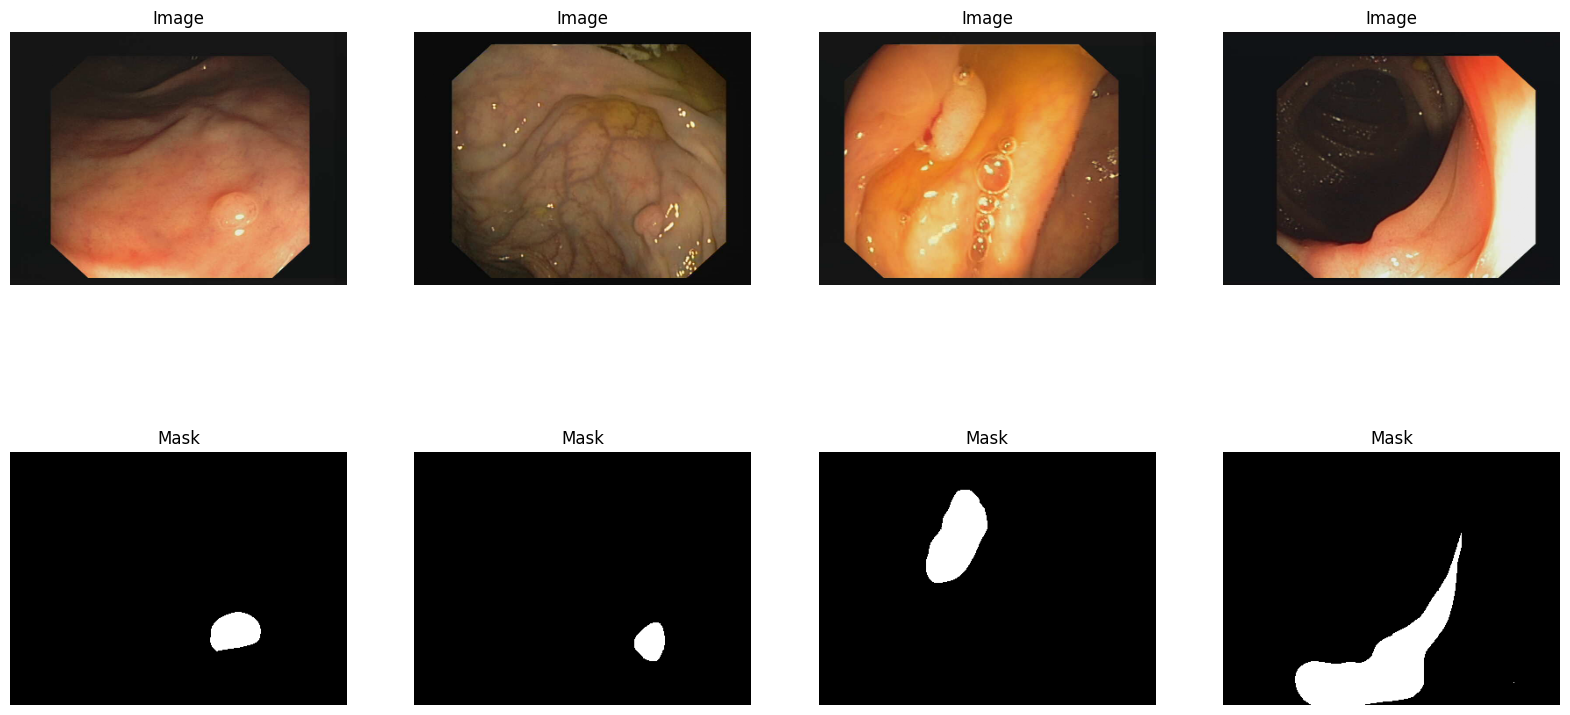

In [8]:
images, masks = next(iter(train_loader))
show(images[:4], masks[:4], num_images=4)

In [9]:
print(len(images), len(masks))
print(images[0].shape, masks[0].shape)

16 16
torch.Size([3, 288, 384]) torch.Size([1, 288, 384])


We will be implementing the U-net architecture, that was implemented in https://github.com/milesial/Pytorch-UNet. For in-depth explanation of the U-net architecture, please refer to https://arxiv.org/abs/1505.04597. 

Quoting the paper : "It consists of a contracting path (left side) and an expansive path (right side). The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.
To allow a seamless tiling of the output segmentation map, it is important to select the input tile size such that all 2x2 max-pooling operations are applied to a layer with an even x- and y-size."

In [10]:
class DoubleConv(nn.Module):
    # 2 x (Conv2D - Batch Norm - ReLU)
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module): # Downscaling with maxpool then double conv
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module): # Upsampling then double conv
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear: # if bilinear, use the normal convolutions to reduce the number of feature channels.
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else: # if not bilinear, use the maxpooling to reduce the number of feature channels
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]) # pad the input

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module): # final convolution
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module): # U-net architecture
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels # number of input channels
        self.n_classes = n_classes # number of output channels
        self.bilinear = bilinear # if bilinear, use the normal convolutions to reduce the number of feature channels.

        self.inc = DoubleConv(n_channels, 64) # 64 -> 128
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x): # input is BxCxHxW
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [11]:
def iou_score(output, target, threshold=0.5): # calculate the intersection over union score
    smooth = 1e-6
    # threshold the output to get the binary mask
    if torch.is_tensor(output):
        output = torch.sigmoid(output)  # sigmoid on output to get probabilities
        output = (output > threshold).float()  # threshold to get binary mask

    if torch.is_tensor(target):
        target = (target > threshold).float() # threshold to get binary mask

    intersection = (output * target).sum(dim=(1, 2, 3)) 
    union = output.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection

    iou = (intersection + smooth) / (union + smooth) # calculate the intersection over union score
    return iou.mean()

def dice_score(output, target, threshold=0.5): # calculate the dice score (https://www.wikiwand.com/en/S%C3%B8rensen%E2%80%93Dice_coefficient) seems to be popular in computer vision
    smooth = 1e-6  # division by zero prevention

    output = torch.sigmoid(output) # sigmoid to get probabilities and threshold to get binary tensor
    output = (output > threshold).float()

    output_flat = output.view(-1)
    target_flat = target.view(-1)

    intersection = (output_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / (output_flat.sum() + target_flat.sum() + smooth)

    return dice



def train_epoch(model, dataloader, optimizer, criterion, device): # train the model for one epoch
    model.train()
    running_loss = 0.0
    iou_total = 0.0
    dice_total = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        iou_total += iou_score(outputs, masks) * images.size(0)
        dice_total += dice_score(outputs, masks).item() * images.size(0)

    # calculate everything
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_iou = iou_total / len(dataloader.dataset)
    epoch_dice = dice_total / len(dataloader.dataset) 
    return epoch_loss, epoch_iou, epoch_dice

def valid_epoch(model, dataloader, criterion, device): 
    model.eval()
    running_loss = 0.0
    iou_total = 0.0
    dice_total = 0.0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)
            iou_total += iou_score(outputs, masks) * images.size(0)
            dice_total += dice_score(outputs, masks).item() * images.size(0)

    # calculate everything
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_iou = iou_total / len(dataloader.dataset)
    epoch_dice = dice_total / len(dataloader.dataset)
    return epoch_loss, epoch_iou, epoch_dice


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
n_channels = 3  # Number of channels in input images (e.g., 3 for RGB)
n_classes = 1   # For binary segmentation
model = UNet(n_channels=n_channels, n_classes=n_classes, bilinear=True)
model.to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
criterion = BCEWithLogitsLoss() # binary cross entropy loss

train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
train_dices, valid_dices = [], []

num_epochs = 200
best_valid_iou = 0.0
best_valid_dice = 0.0

for epoch in range(num_epochs):
    train_loss, train_iou, train_dice = train_epoch(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_iou, valid_dice = valid_epoch(model, validate_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_iou)
    valid_accuracies.append(valid_iou)
    train_dices.append(train_dice)
    valid_dices.append(valid_dice)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Train IoU: {train_iou}, Valid IoU: {valid_iou}, Train IoU: {train_dice}, Valid IoU: {valid_dice}')
    if (epoch + 1) % 10 == 0:
        if valid_iou > best_valid_iou:
            best_valid_iou = valid_iou
            save_path = f'{dataset_path}/model_epoch_{epoch+1}_iou_{valid_iou:.4f}.pt'
            torch.save(model.state_dict(), save_path)
            print(f'Model saved to {save_path}')

cuda
Epoch 1/200, Train Loss: 0.5082489413635753, Valid Loss: 0.5586734833298149, Train IoU: 0.23603495955467224, Valid IoU: 0.009618984535336494, Train IoU: 0.4281534223913032, Valid IoU: 0.01870010093181998
Epoch 2/200, Train Loss: 0.3990512637891502, Valid Loss: 0.4382446113523546, Train IoU: 0.2846127450466156, Valid IoU: 0.22658413648605347, Train IoU: 0.5046929661358628, Valid IoU: 0.4334493502155765
Epoch 3/200, Train Loss: 0.3521420638137889, Valid Loss: 0.3219458329808581, Train IoU: 0.3763643205165863, Valid IoU: 0.4023727774620056, Train IoU: 0.5932866279209885, Valid IoU: 0.6243039218934028
Epoch 4/200, Train Loss: 0.32197714269718275, Valid Loss: 0.31426064882959637, Train IoU: 0.42639145255088806, Valid IoU: 0.3850242793560028, Train IoU: 0.6418494292508776, Valid IoU: 0.5944878865074326
Epoch 5/200, Train Loss: 0.3089189755025311, Valid Loss: 0.31829591734068735, Train IoU: 0.42522117495536804, Valid IoU: 0.4118436872959137, Train IoU: 0.6439769279176943, Valid IoU: 0.62

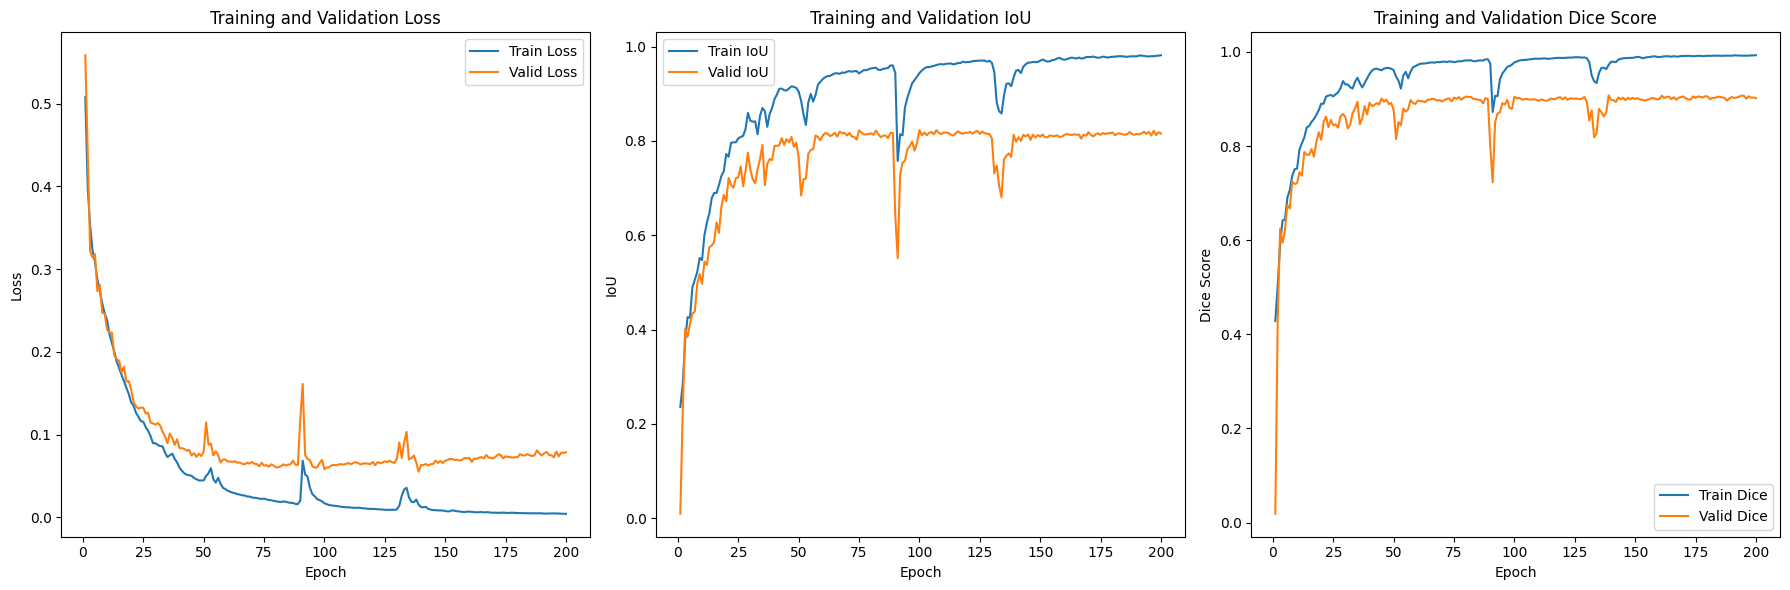

In [17]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

train_accuracies_np = np.array([x.item() if torch.is_tensor(x) else x for x in train_accuracies])
valid_accuracies_np = np.array([x.item() if torch.is_tensor(x) else x for x in valid_accuracies])


plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs+1), train_accuracies_np, label='Train IoU')
plt.plot(range(1, num_epochs+1), valid_accuracies_np, label='Valid IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Training and Validation IoU')
plt.legend()

train_dice_scores_np = np.array([x.item() if torch.is_tensor(x) else x for x in train_dices])
valid_dice_scores_np = np.array([x.item() if torch.is_tensor(x) else x for x in valid_dices])

plt.subplot(1, 3, 3)
plt.plot(range(1, num_epochs+1), train_dice_scores_np, label='Train Dice')
plt.plot(range(1, num_epochs+1), valid_dice_scores_np, label='Valid Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training and Validation Dice Score')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
print(valid_iou, valid_dice)

tensor(0.8155, device='cuda:0') 0.9017339695940961


In [15]:
save_path = f'{dataset_path}/model_epoch_{epoch+1}_iou_{valid_iou:.4f}.pt'
torch.save(model.state_dict(), save_path)

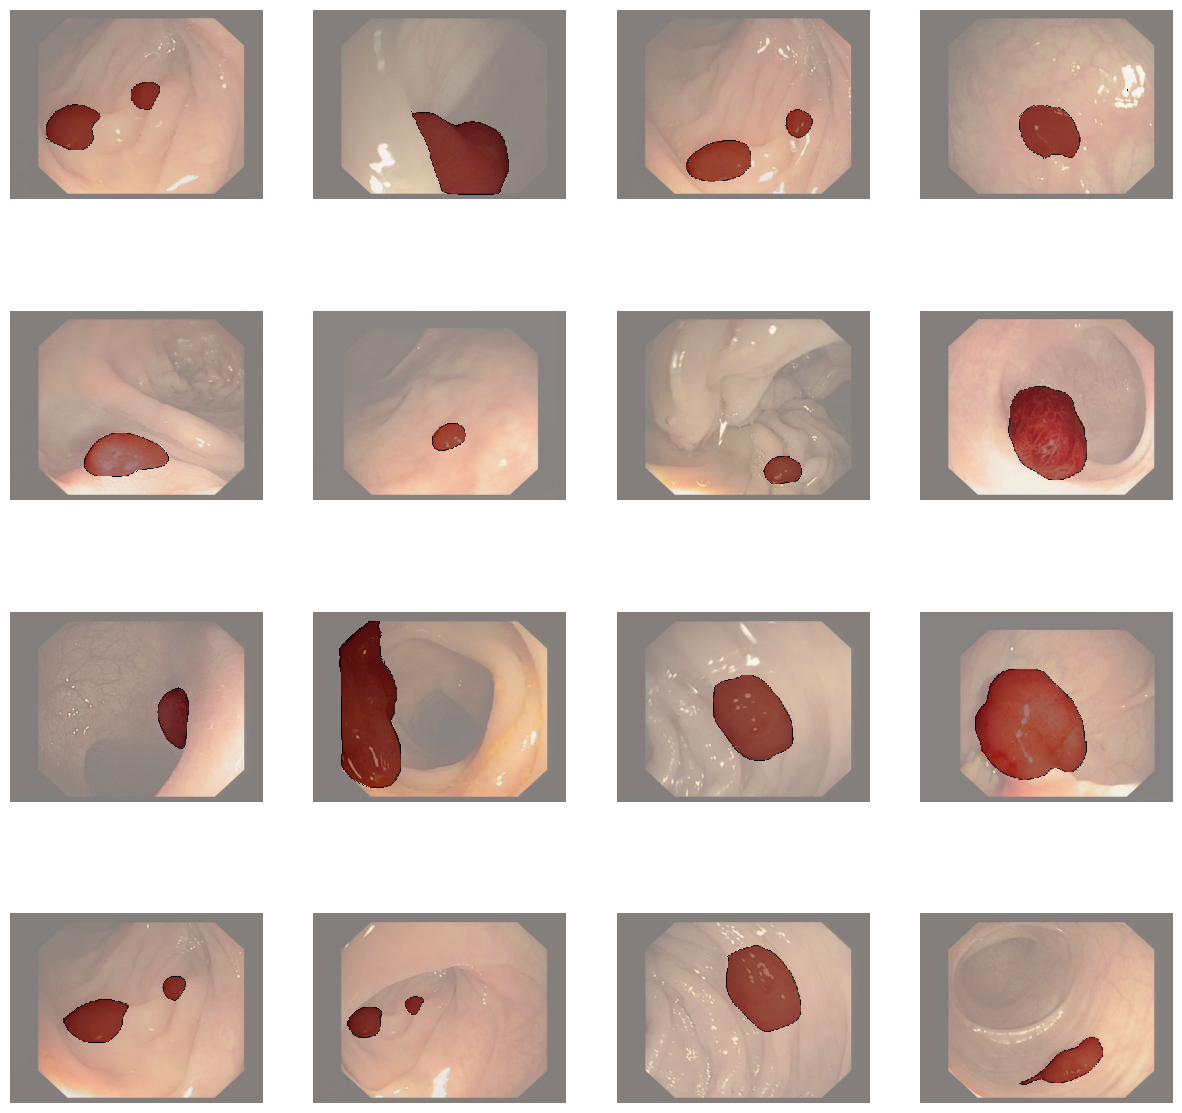

In [20]:
def plot_images_with_masks_and_edges(images, preds, ground_truth, num_images=16): # plot predictions and ground truth images with masks
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(4, 4, i+1)
        img = images[i].cpu().data.numpy()
        img = np.transpose(img, (1, 2, 0))
        plt.imshow(img)

        # overlay predicted mask
        pred_mask = preds[i].cpu().squeeze().numpy()
        plt.imshow(pred_mask, alpha=0.5, cmap='Reds', interpolation='none')  # prediction in red

        # find edges of ground truth mask to draw
        ground_truth_mask = ground_truth[i].cpu().squeeze().numpy()
        eroded = binary_erosion(ground_truth_mask)
        edges = ground_truth_mask - eroded
        edges = np.ma.masked_where(edges == 0, edges)  # mask where there are no edges

        # overlay edges of ground truth mask
        plt.imshow(edges, alpha=1.0, cmap='gray', interpolation='none')  # Edges in black

        plt.axis('off')
    plt.show()

# bunch of different ways to plot images
def plot_images(images, preds, num_images=16):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        img = images[i].cpu().data.numpy()
        img = np.transpose(img, (1, 2, 0))
        plt.imshow(img)
        plt.imshow(preds[i].cpu().squeeze().numpy(), alpha=0.6, cmap='jet')  # Overlay mask
        plt.axis('off')
    plt.show()

def plot_images_with_masks(images, preds, ground_truth, num_images=16): # since too much overlay, difficult to judge
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(4, 4, i+1)
        img = images[i].cpu().data.numpy()
        img = np.transpose(img, (1, 2, 0))
        plt.imshow(img)
        # Overlay predicted mask
        plt.imshow(preds[i].cpu().squeeze().numpy(), alpha=0.6, cmap='Reds', interpolation='none')  # predicted in red
        # Overlay ground truth mask
        plt.imshow(ground_truth[i].cpu().squeeze().numpy(), alpha=0.8, cmap='Blues', interpolation='none')  # ground truth in blue
        plt.axis('off')
    plt.show()


images, ground_truth = next(iter(train_loader))
images = images.to(device)
ground_truth = ground_truth.to(device)

#print(len(images))
with torch.no_grad():
    outputs = model(images)
    probs = torch.sigmoid(outputs)
    preds = (probs > 0.5).float()

plot_images_with_masks_and_edges(images, preds, ground_truth, num_images=16)

Model seems to be working fine, and there is a strong overlap between the predictions and the ground truth. The edged part shows the edges of the ground truth mask, while the predictions is highlighted in red.

The final validation IOU and DICE score are 0.8155 and 0.901. This seems not bad for a model that was trained for only 200 epochs (roughly half hour in V100 GPU).
The top ranking model DUCK-Net has IOU and DICE, 0.934 and 0.9684 respectively. The achieved score is comparable to 28/29th ranking model DoubleUnet-DCA which has 0.8347 and 0.9086 respectively.